In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, precision_recall_curve, auc, precision_score,
                             PrecisionRecallDisplay, RocCurveDisplay)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 0. Загрузка данных

In [2]:
df = pd.read_csv('../content/salary.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## 1. Базовое решение

### 1.1 Минимальные преобразования

In [8]:
# посмотрим на целевой признак

df['salary'].value_counts()

 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

In [5]:
columns = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [11]:
dummies = pd.get_dummies(df['salary'])
df = pd.concat([df, dummies], axis=1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,<=50K,>50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,1,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,1,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,1,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,1,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K,1,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K,0,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K,1,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K,1,0


### 1.2 Обучение модели

In [17]:
X = df[columns]
y = df[' >50K']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,             # применим из-за дисбаланса классов
                                                    random_state=42)
X_train.shape, X_test.shape

((26048, 6), (6513, 6))

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [19]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
pred_proba_test = lr.predict_proba(X_test)

### 1.3 Подсчет метрик качества

In [20]:
# для train'а
print(classification_report(y_train, pred_train))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88     19775
           1       0.72      0.26      0.38      6273

    accuracy                           0.80     26048
   macro avg       0.76      0.61      0.63     26048
weighted avg       0.78      0.80      0.76     26048



In [21]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88      4945
           1       0.72      0.27      0.40      1568

    accuracy                           0.80      6513
   macro avg       0.76      0.62      0.64      6513
weighted avg       0.79      0.80      0.76      6513



<Figure size 1200x1000 with 0 Axes>

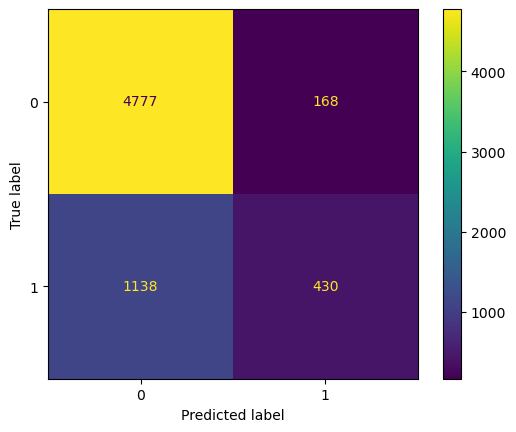

In [22]:
# матрица ошибок
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, pred_test, labels=lr.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
display.plot()
plt.show();

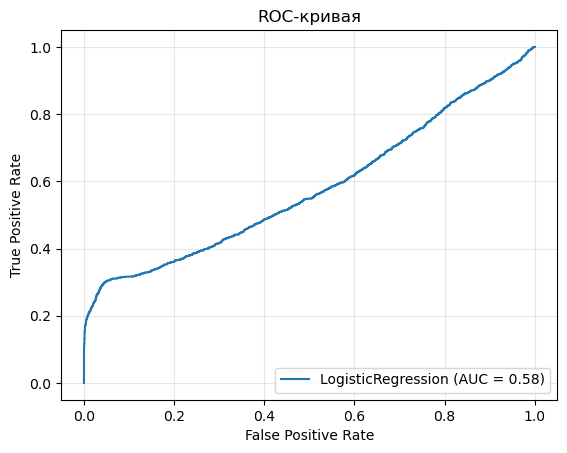

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr
                          , roc_auc=auc(fpr, tpr)
                          , estimator_name='LogisticRegression')
display.plot()
plt.title('ROC-кривая')
plt.grid(True, alpha=.3)
plt.show()

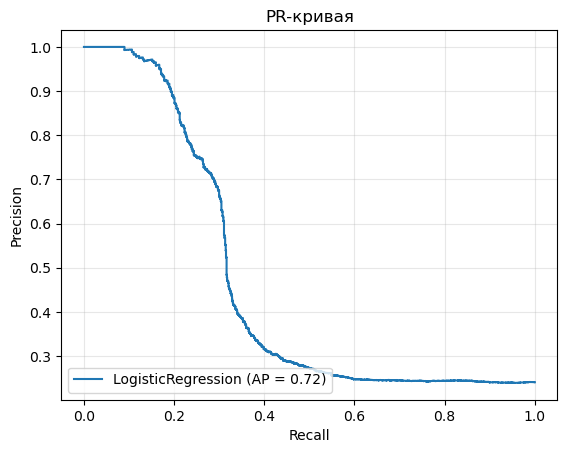

In [24]:
pr, r, _ = precision_recall_curve(y_test, pred_proba_test[:, 1])            # для класса 1

display = PrecisionRecallDisplay(precision=pr, recall=r
                                 , average_precision=precision_score(y_test, pred_test)
                                 , estimator_name='LogisticRegression')
display.plot()
plt.title("PR-кривая")
plt.grid(True, alpha=.3)
plt.show()

## 2. Разделение данных на обучающие и тестовые

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=42)
X_train.shape, X_test.shape

((227845, 30), (56962, 30))

In [20]:
y_train.value_counts(normalize=True)

0    0.998271
1    0.001729
Name: Class, dtype: float64

In [21]:
y_test.value_counts(normalize=True)

0    0.99828
1    0.00172
Name: Class, dtype: float64

## 3. Балансировка данных минимум тремя методами

In [22]:
def balance_df_by_target(df, target_idx, method='over'):
    # df здесь - numpy-массив

    assert method in ['over', 'under', 'smote'], 'Неверный метод сэмплирования'

    df[target_idx] = df[target_idx].astype('int')
    target_counts = df[target_idx].value_counts()       # перевели в DataFrame

    major_class_name = target_counts.argmax()           # имя класса с бОльшим количеством объектов
    minor_class_name = target_counts.argmin()           # имя класса с меньшим количеством объектов

    # во сколько раз большего класса больше, чем меньшего
    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for _ in range(disbalance_coeff):
            sample = df[df[target_idx] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)

    elif method == 'under':
        df_ = df.copy()                     # на всякий случай работаем с копией
        df = df_[df_[target_idx] == minor_class_name]
        tmp = df_[df_[target_idx] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'smote':
        # генерация синтетических данных
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_idx), df[target_idx])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1)

In [23]:
import numpy as np

# преобразование обучающих данных в конкатенацию вдоль второй оси (по столбцам) - датасет тренировочных данных для балансировки
df_for_balancing = pd.DataFrame(np.c_[X_train, y_train.values])
df_for_balancing.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,0.0
1,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,0.0
2,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,0.0
3,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,0.0
4,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,0.0


In [24]:
TARGET_NAME = 30

### 3.1 Балансировка методом oversampling

In [25]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')

df_balanced[TARGET_NAME].value_counts()

0    227451
1    227338
Name: 30, dtype: int64

In [26]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

0.99950


### 3.2 Балансировка методом undersampling

In [27]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')

df_balanced[TARGET_NAME].value_counts()

0    394
1    394
Name: 30, dtype: int64

In [28]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

1.00000


### 3.3 Балансировка методом `SMOTE`

In [29]:
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')

df_balanced[TARGET_NAME].value_counts()

0    227451
1    227451
Name: 30, dtype: int64

In [30]:
# степень расхождения классов
print(f"{df_balanced[TARGET_NAME].value_counts()[1] / df_balanced[TARGET_NAME].value_counts()[0]:.5f}")

1.00000


## 4. Обучение модели классификации с целевым признаком `CLass`

In [31]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [32]:
lr = LogisticRegression()
lr.fit(X_train_balanced, y_train_balanced)
pred_train = lr.predict(X_train_balanced)
pred_test = lr.predict(X_test)
pred_proba_test = lr.predict_proba(X_test)

## 5. Оценка метрик качества

<Figure size 1200x1000 with 0 Axes>

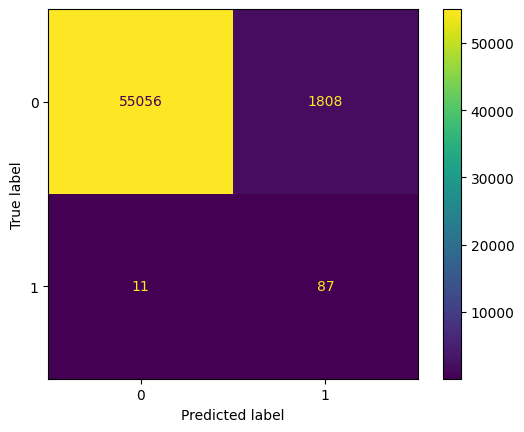

In [33]:
# матрица ошибок
plt.figure(figsize=(12, 10))

cm = confusion_matrix(y_test, pred_test, labels=lr.classes_)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
display.plot()
plt.show();

In [34]:
# для train'а
print(classification_report(y_train_balanced, pred_train))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96    227451
           1       0.97      0.94      0.96    227451

    accuracy                           0.96    454902
   macro avg       0.96      0.96      0.96    454902
weighted avg       0.96      0.96      0.96    454902



In [35]:
# для test'а
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56864
           1       0.05      0.89      0.09        98

    accuracy                           0.97     56962
   macro avg       0.52      0.93      0.54     56962
weighted avg       1.00      0.97      0.98     56962



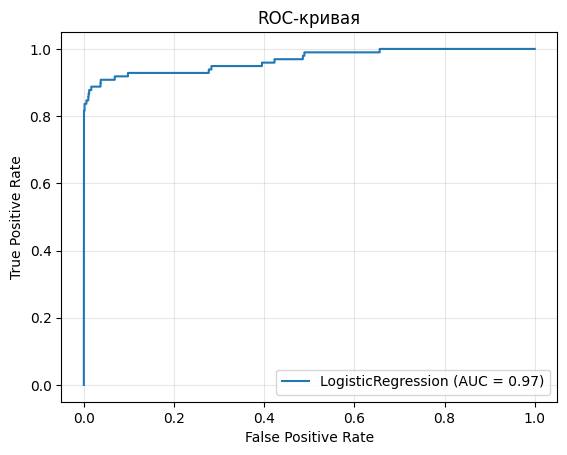

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr
                          , roc_auc=auc(fpr, tpr)
                          , estimator_name='LogisticRegression')
display.plot()
plt.title('ROC-кривая')
plt.grid(True, alpha=.3)
plt.show()

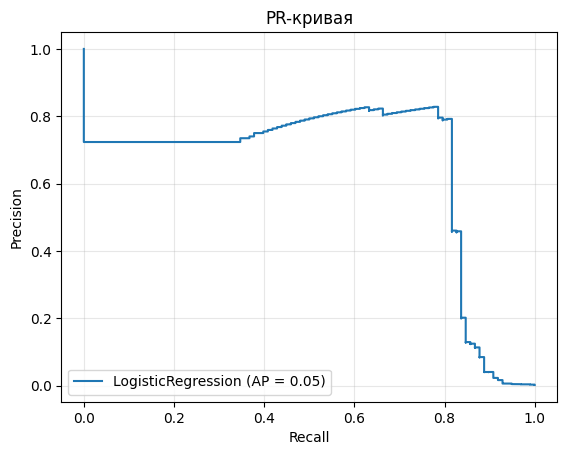

In [37]:
pr, r, _ = precision_recall_curve(y_test, pred_proba_test[:, 1])            # для класса 1

display = PrecisionRecallDisplay(precision=pr, recall=r
                                 , average_precision=precision_score(y_test, pred_test)
                                 , estimator_name='LogisticRegression')
display.plot()
plt.title("PR-кривая")
plt.grid(True, alpha=.3)
plt.show()

## 6. Выводы о проделанной работе

**Базовое решение:**

F1-score (для теста, макроусреднённая) равна **0.86**. Площадь под ROC-кривой - **0.94**. Средняя точность - **0.76**.

**Решение с балансировкой целевого признака:**

F1-score (для трейна, макроусреднённая) равна **0.96**, F1-score (для теста, макроусреднённая) равна **0.54**, . Площадь под ROC-кривой - **0.97**. Средняя точность - **0.05**.


Модель стала заметно лучше работать на обучающих данных по причине того, что они были сбалансированы, а на тесте показала результаты хуже, поскольку тестовые данные сбалансированы не были